In [2]:
!pip install pandas
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install numpy

     |████████████████████████████████| 9.9 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 42.1 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 59.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 46.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 56.5 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 4.3 MB/s eta 0:00:01


In [3]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# df = pd.read_excel('IDD_To_Train.xlsx')
df = pd.read_csv('IDDROI_AggregatedData_T0-R0.csv')

In [5]:
df

,DateModified,Country,Adobe_Unique Visitors,Adobe_Engaged Visits,Utilization_Tests,SearchTrend_Value,Email_Opens,Sales_Calls,Utilization_MemberCount
0,12/30/18,Belgium,38,10,82949,3013302,0,28,76
1,12/30/18,France,456,89,111877,24803934,0,335,70
2,12/30/18,Germany,302,61,105602,31000059,0,90,88
3,12/30/18,United Kingdom,754,254,41652,52951089,0,95,11
4,12/30/18,Italy,387,74,91897,22975494,0,176,143
...,...,...,...,...,...,...,...,...,...
955,6/2/19,Estonia,0,0,14823,0,0,0,6
956,7/14/19,Estonia,0,0,7865,1392862,0,0,6
957,11/17/19,Estonia,0,0,13235,703064,0,0,6
958,12/1/19,Estonia,0,0,12663,875513,0,0,6


In [6]:
#Model some type of nonlinearity
df['drdr'] = df['Utilization_MemberCount']*df['Utilization_MemberCount']
df['log2dr'] = np.log2(df['Utilization_MemberCount'])

In [7]:
#Scale SearchTrend_Value
df['SearchTrend_Modified'] = df['SearchTrend_Value']/1000

In [8]:
#Fix any place where the log2 is -infinity (log of 0)
df.loc[df['log2dr']==-np.inf,'log2dr'] = 0

In [9]:
# train = df[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Revenue','Calls','Tenure']]
# X = train[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Calls','Tenure']]
# X_ols = train[['AffectedPop','UV','NumReps','Staffed']]
train = df[['DateModified','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr','Utilization_Tests']]
X = train[['DateModified','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']]
X_ols = train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']]
y = train['Utilization_Tests']

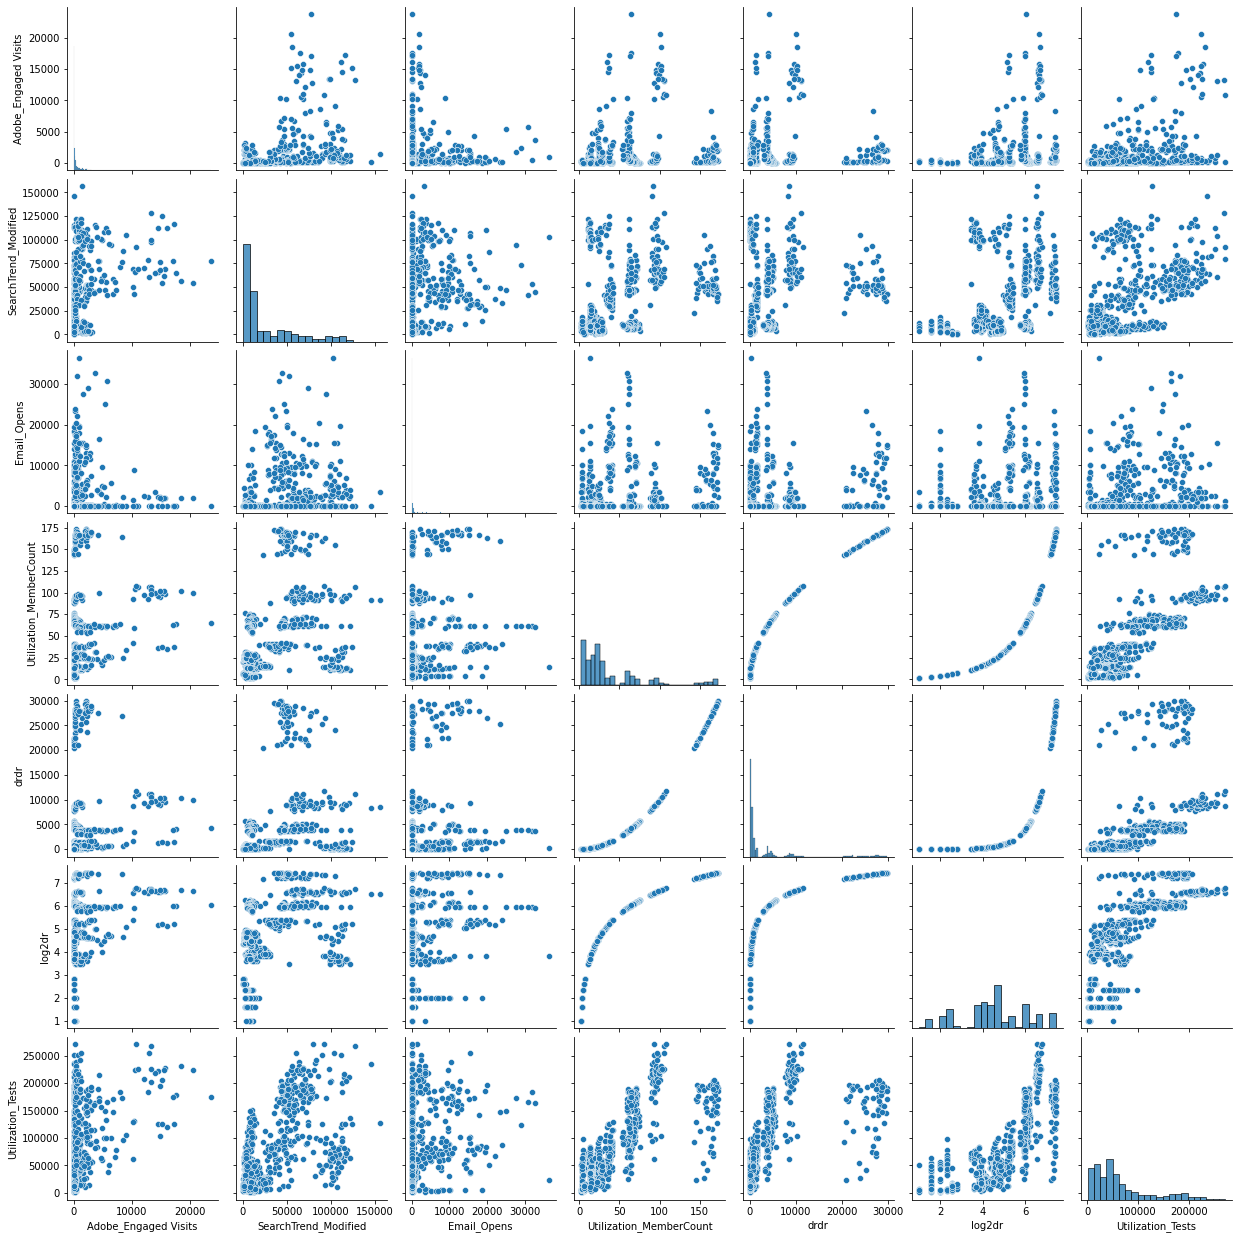

In [10]:
#Look at interactions between the variables. Not very many great relationships except definitely some interactions between # of Drs and Revenue
sns.pairplot(train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Utilization_MemberCount','drdr','log2dr','Utilization_Tests']])
plt.show()

In [11]:
!pip install sklearn

     |████████████████████████████████| 22.3 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 39.6 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=059b3e513727ada19578229389e547e93b8d67d8966e033cd245697ba6abab51
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [12]:
#Split the data into train/test datasets and get ready to build a random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor()
X = pd.get_dummies(X)

x_train, x_test, y_train, y_test = train_test_split(X,y)

In [13]:
#Train an OLS regression on the original dataset (NOT INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(x_train[train_test_cols])
x_train_orig = sm.tools.add_constant(x_train[train_test_cols[:-2]])
mod = sm.GLS(y_train, x_train_orig)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(x_test[train_test_cols[:-2]])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.733
Model:                            GLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     391.2
Date:                Tue, 27 Apr 2021   Prob (F-statistic):          1.03e-201
Time:                        17:57:38   Log-Likelihood:                -8478.5
No. Observations:                 720   AIC:                         1.697e+04
Df Residuals:                     714   BIC:                         1.700e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

In [14]:
#Train an OLS regression on the modified dataset (INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(x_train[train_test_cols])
x_train_orig = sm.tools.add_constant(x_train[train_test_cols[:-2]])
mod = sm.GLS(y_train, x_train_all)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(x_test[train_test_cols])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.822
Model:                            GLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     470.2
Date:                Tue, 27 Apr 2021   Prob (F-statistic):          4.76e-262
Time:                        17:57:53   Log-Likelihood:                -8331.7
No. Observations:                 720   AIC:                         1.668e+04
Df Residuals:                     712   BIC:                         1.672e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    4

In [15]:
#Fit the random forest and predict the values for the test dataset

rf.fit(x_train,y_train)
y_predict_rf = rf.predict(x_test)

In [16]:
#Which variables are most important for the random forest? Number of doctors is the strongest predictor
importances = pd.DataFrame(list(zip(*[x_train.columns,rf.feature_importances_])),columns=['variable','importance'])
importances.sort_values('importance',ascending=False)

,variable,importance
4,Utilization_MemberCount,0.283629
6,log2dr,0.250938
5,drdr,0.212482
3,Sales_Calls,0.122987
1,SearchTrend_Modified,0.034614
...,...,...
20,DateModified_11/29/20,0.000034
17,DateModified_11/1/20,0.000028
15,DateModified_10/4/20,0.000025
64,DateModified_9/22/19,0.000020


In [17]:
#Import functions to calculate metrics from sklearn to make it easier to ensure I'm calculating it correctly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
mse_rf = mean_squared_error(y_test, y_predict_rf)
mae_rf = mean_absolute_error(y_test, y_predict_rf)
r2_rf = r2_score(y_test, y_predict_rf)
mse_ols = mean_squared_error(y_test, y_predict_ols)
mae_ols = mean_absolute_error(y_test, y_predict_ols)
r2_ols = r2_score(y_test, y_predict_ols)

print(f'OLS\nMSE: {mse_ols:0,.0f}\t\tMAE: {mae_ols:0,.1f}\t\tR-Squared: {r2_ols:0.3f}')
print()
print(f'Random Forest\nMSE: {mse_rf:0,.0f}\t\tMAE: {mae_rf:0,.1f}\t\tR-Squared: {r2_rf:0.3f}')

OLS
MSE: 748,381,707		MAE: 19,381.9		R-Squared: 0.777

Random Forest
MSE: 258,877,830		MAE: 9,662.5		R-Squared: 0.923


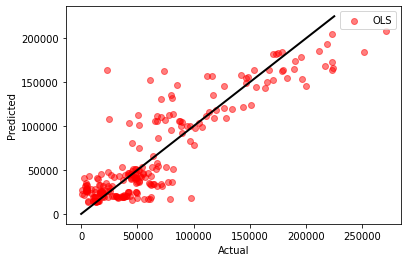

In [19]:
#How closely to the y=x line do the OLS predictions run?
plt.scatter(y_test, y_predict_ols, alpha=0.5, c='r', label='OLS')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

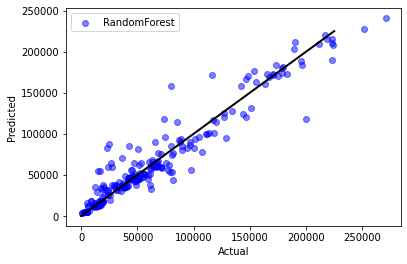

In [20]:
#How closely to the y=x line do the random forest predictions run?
plt.scatter(y_test, y_predict_rf, alpha=0.5, c='b', label='RandomForest')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()